In [1]:
#Code Source: https://www.kaggle.com/dragonoken/churn-modelling-with-pytorch/notebook

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import os
import seaborn as sns

### Data Reviewing

In [2]:
os.chdir("C:\\Users\\kusalh\\Documents\\Courses")
BD = pd.read_csv('Courses.csv')
BD.head()

,ID,course,completed,upgraded,gender,country,age,education,job,major,...,completion_year,completion_month,completion_day,completion_hour,completion_minute,upgrade_year,upgrade_month,upgrade_day,upgrade_hour,upgrade_minute
0,284921427,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,284926400,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,284946595,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,285755462,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,285831220,1,1,0,0,0,0,0,0,0,...,2011,5,29,15,58,0,0,0,0,0


[Text(0.5, 0, 'ID'),
 Text(2.5, 0, 'completed'),
 Text(4.5, 0, 'gender'),
 Text(6.5, 0, 'age'),
 Text(8.5, 0, 'job'),
 Text(10.5, 0, 'logged_location'),
 Text(12.5, 0, 'registration_month'),
 Text(14.5, 0, 'registration_hour'),
 Text(16.5, 0, 'withdrawl_year'),
 Text(18.5, 0, 'withdrawl_day'),
 Text(20.5, 0, 'withdrawl_minute'),
 Text(22.5, 0, 'completion_month'),
 Text(24.5, 0, 'completion_hour'),
 Text(26.5, 0, 'upgrade_year'),
 Text(28.5, 0, 'upgrade_day'),
 Text(30.5, 0, 'upgrade_minute')]

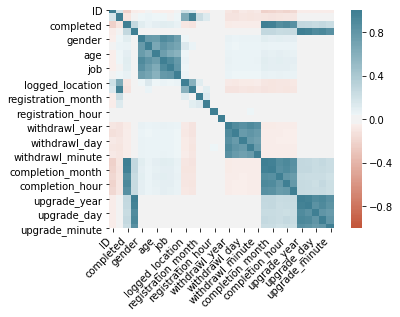

In [5]:
# BD['upgraded'].sum()
corr = BD.corr()
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
)


### Preprocessing 

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler
from collections import OrderedDict

### Moving on to Pytorch

In [7]:
# date values are not important unless engineered
DF = BD.drop([
                'ID',
#                 'upgraded',
#             ], axis=1)
            'registration_year',
            'registration_month',
            'registration_day',
            'registration_hour',
            'registration_minute',
            'withdrawl_year',
            'withdrawl_month',
            'withdrawl_day',
            'withdrawl_hour',
            'withdrawl_minute',
            'completion_year',
            'completion_month',
            'completion_day',
            'completion_hour',
            'completion_minute',
            'upgrade_year',
            'upgrade_month',
            'upgrade_day',
            'upgrade_hour',
            'upgrade_minute'
        ], axis=1)
DF

,course,completed,upgraded,gender,country,age,education,job,major,logged_location
0,1,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,56
4,1,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...
24995,3,0,0,0,0,0,0,0,0,56
24996,3,0,0,0,0,0,0,0,0,56
24997,3,0,0,0,0,0,0,0,0,171
24998,3,0,0,0,0,0,0,0,0,56


### Feature engineering

In [8]:
withdrew = pd.Series((BD['withdrawl_day'].map(int) != 0).map(int), name="withdrew")
# completed = pd.Series((BD['completion_day'].map(int) != 0).map(int), name="completed")

DF = pd.concat([DF, withdrew], axis=1)

In [10]:
# yer = BD['completion_year'].max()
# mon = BD['completion_month'].max()
# day = BD['completion_day'].max()
# yer = BD['completion_year'][BD['completion_year'] != 0].min()
# mon = BD['completion_month'][BD['completion_month'] != 0].min()
# day = BD['completion_day'][BD['completion_day'] != 0].min()
# yer, mon, day

# Date buckets min and max

# reg: first='2010-1-1' last='2013-12-12'
# wit: first='2011-1-1' last='2013-12-31'
# com: first='2011-1-1' last='2013-12-31'
# upg: first='2011-1-1' last='2013-12-31'



In [9]:
# day_of_reg = pd.Series(BD['registration_year'].map(str) + "-" + BD['registration_month'].map(str) + "-" + BD['registration_day'].map(str), name="DoR")
# day_of_with = pd.Series(BD['withdrawl_year'].map(str) + "-" + BD['withdrawl_month'].map(str) + "-" + BD['withdrawl_day'].map(str), name="DoW")
# day_of_com = pd.Series(BD['completion_year'].map(str) + "-" + BD['completion_month'].map(str) + "-" + BD['completion_day'].map(str), name="DoC")
# day_of_upg = pd.Series(BD['upgrade_year'].map(str) + "-" + BD['upgrade_month'].map(str) + "-" + BD['upgrade_day'].map(str), name="DoU")

reg_month = pd.Series(BD['registration_year'].map(str) + "_" + BD['registration_month'].map(str), name="MoR")

# DF = pd.concat([DF, day_of_reg, day_of_with, day_of_com, day_of_upg], axis=1)
DF = pd.concat([DF, reg_month], axis=1)
DF

,course,completed,upgraded,gender,country,age,education,job,major,logged_location,withdrew,MoR
0,1,0,0,0,0,0,0,0,0,0,1,2011_2
1,1,0,0,0,0,0,0,0,0,0,1,2011_3
2,1,0,0,0,0,0,0,0,0,0,1,2011_2
3,1,0,0,0,0,0,0,0,0,56,1,2011_4
4,1,1,0,0,0,0,0,0,0,0,0,2011_2
...,...,...,...,...,...,...,...,...,...,...,...,...
24995,3,0,0,0,0,0,0,0,0,56,0,2013_7
24996,3,0,0,0,0,0,0,0,0,56,1,2013_3
24997,3,0,0,0,0,0,0,0,0,171,1,2013_4
24998,3,0,0,0,0,0,0,0,0,56,1,2013_5


In [11]:
# phases = {'registration': day_of_reg, 'withdrawl':day_of_with, 'completion':day_of_com}
phases = ['registration', 'withdrawl', 'completion', 'upgrade']
buckets = {}

for phase in phases:
    y = phase + '_year'
    m = phase + '_month'
    
    years = BD[y][BD[y] != 0].unique()
    years.sort()
    months = BD[m][BD[m] != 0].unique()
    months.sort()
    bucket = {}
    for year in years:
        for month in months:
            count = len(BD[BD[phase + '_year'] == year][BD[phase + '_month'] == month])
            bucket[str(year) + "_" + str(month)] = count
    buckets[phase] = bucket
buckets

C:\Users\kusalh\AppData\Local\Continuum\miniconda3\envs\course\lib\site-packages\ipykernel_launcher.py:16: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  app.launch_new_instance()


{'registration': {'2010_1': 0,
  '2010_2': 0,
  '2010_3': 0,
  '2010_4': 0,
  '2010_5': 0,
  '2010_6': 0,
  '2010_7': 0,
  '2010_8': 0,
  '2010_11': 0,
  '2010_12': 1,
  '2011_1': 0,
  '2011_2': 3198,
  '2011_3': 2005,
  '2011_4': 3320,
  '2011_5': 1013,
  '2011_6': 459,
  '2011_7': 1,
  '2011_8': 0,
  '2011_11': 2,
  '2011_12': 1249,
  '2012_1': 1871,
  '2012_2': 2161,
  '2012_3': 3820,
  '2012_4': 703,
  '2012_5': 191,
  '2012_6': 2,
  '2012_7': 0,
  '2012_8': 1,
  '2012_11': 0,
  '2012_12': 0,
  '2013_1': 0,
  '2013_2': 2,
  '2013_3': 694,
  '2013_4': 338,
  '2013_5': 2863,
  '2013_6': 671,
  '2013_7': 416,
  '2013_8': 19,
  '2013_11': 0,
  '2013_12': 0},
 'withdrawl': {'2011_1': 0,
  '2011_2': 14,
  '2011_3': 33,
  '2011_4': 194,
  '2011_5': 299,
  '2011_6': 207,
  '2011_7': 88,
  '2011_8': 75,
  '2011_9': 88,
  '2011_10': 64,
  '2011_11': 35,
  '2011_12': 24,
  '2012_1': 69,
  '2012_2': 95,
  '2012_3': 362,
  '2012_4': 277,
  '2012_5': 175,
  '2012_6': 105,
  '2012_7': 70,
  '2012

In [12]:
rates = pd.DataFrame(buckets).reset_index()
rates = rates.dropna()
rates

,index,registration,withdrawl,completion,upgrade
10,2011_1,0.0,0.0,0.0,0.0
11,2011_2,3198.0,14.0,0.0,0.0
12,2011_3,2005.0,33.0,0.0,0.0
13,2011_4,3320.0,194.0,22.0,2.0
14,2011_5,1013.0,299.0,570.0,14.0
15,2011_6,459.0,207.0,414.0,53.0
16,2011_7,1.0,88.0,63.0,15.0
17,2011_8,0.0,75.0,29.0,4.0
18,2011_11,2.0,35.0,6.0,4.0
19,2011_12,1249.0,24.0,3.0,2.0


In [13]:
# inf rate is interpretted as 100% and NaN rates caused by division by zero interpretted as 0%
rates['subscribers'] = rates['registration'].cumsum() - rates['withdrawl'].cumsum()
rates['subscribe_rate'] = rates['registration'] * 100 / (rates['subscribers'] + rates['withdrawl'] - rates['registration'])
rates['churn_rate'] = rates['withdrawl'] * 100 / (rates['subscribers'] + rates['withdrawl'] - rates['registration'])
rates['upgrade_rate'] = rates['upgrade'] * 100 / (rates['subscribers'] + rates['withdrawl'] - rates['registration'])
rates['completion_rate'] = rates['completion'] * 100 / (rates['subscribers'] + rates['withdrawl'] - rates['registration'])
rates = rates.replace(np.nan, 0)
rates = rates.replace(np.inf, 100)
rates

,index,registration,withdrawl,completion,upgrade,subscribers,subscribe_rate,churn_rate,upgrade_rate,completion_rate
10,2011_1,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000
11,2011_2,3198.0,14.0,0.0,0.0,3184.0,100.000000,100.000000,0.000000,0.000000
12,2011_3,2005.0,33.0,0.0,0.0,5156.0,62.971106,1.036432,0.000000,0.000000
13,2011_4,3320.0,194.0,22.0,2.0,8282.0,64.391001,3.762607,0.038790,0.426687
14,2011_5,1013.0,299.0,570.0,14.0,8996.0,12.231345,3.610239,0.169041,6.882396
15,2011_6,459.0,207.0,414.0,53.0,9248.0,5.102268,2.301023,0.589151,4.602045
16,2011_7,1.0,88.0,63.0,15.0,9161.0,0.010813,0.951557,0.162197,0.681228
17,2011_8,0.0,75.0,29.0,4.0,9086.0,0.000000,0.818688,0.043663,0.316559
18,2011_11,2.0,35.0,6.0,4.0,9053.0,0.022012,0.385208,0.044024,0.066036
19,2011_12,1249.0,24.0,3.0,2.0,10278.0,13.796532,0.265105,0.022092,0.033138


In [14]:
plt.figure(figsize=(28, 10))

<Figure size 2016x720 with 0 Axes>

<Figure size 2016x720 with 0 Axes>

[Text(0, 0, '2011_1'),
 Text(0, 0, '2011_11'),
 Text(0, 0, '2011_12'),
 Text(0, 0, '2011_2'),
 Text(0, 0, '2011_3'),
 Text(0, 0, '2011_4'),
 Text(0, 0, '2011_5'),
 Text(0, 0, '2011_6'),
 Text(0, 0, '2011_7'),
 Text(0, 0, '2011_8'),
 Text(0, 0, '2012_1'),
 Text(0, 0, '2012_11'),
 Text(0, 0, '2012_12'),
 Text(0, 0, '2012_2'),
 Text(0, 0, '2012_3'),
 Text(0, 0, '2012_4'),
 Text(0, 0, '2012_5'),
 Text(0, 0, '2012_6'),
 Text(0, 0, '2012_7'),
 Text(0, 0, '2012_8'),
 Text(0, 0, '2013_1'),
 Text(0, 0, '2013_11'),
 Text(0, 0, '2013_12'),
 Text(0, 0, '2013_2'),
 Text(0, 0, '2013_3'),
 Text(0, 0, '2013_4'),
 Text(0, 0, '2013_5'),
 Text(0, 0, '2013_6'),
 Text(0, 0, '2013_7'),
 Text(0, 0, '2013_8')]

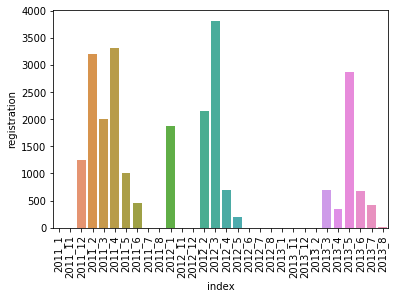

In [15]:
plot = sns.barplot(x="index", y="registration", data=rates)
plot.set_xticklabels(plot.get_xticklabels(), rotation=90)

[Text(0, 0, '2011_1'),
 Text(0, 0, '2011_11'),
 Text(0, 0, '2011_12'),
 Text(0, 0, '2011_2'),
 Text(0, 0, '2011_3'),
 Text(0, 0, '2011_4'),
 Text(0, 0, '2011_5'),
 Text(0, 0, '2011_6'),
 Text(0, 0, '2011_7'),
 Text(0, 0, '2011_8'),
 Text(0, 0, '2012_1'),
 Text(0, 0, '2012_11'),
 Text(0, 0, '2012_12'),
 Text(0, 0, '2012_2'),
 Text(0, 0, '2012_3'),
 Text(0, 0, '2012_4'),
 Text(0, 0, '2012_5'),
 Text(0, 0, '2012_6'),
 Text(0, 0, '2012_7'),
 Text(0, 0, '2012_8'),
 Text(0, 0, '2013_1'),
 Text(0, 0, '2013_11'),
 Text(0, 0, '2013_12'),
 Text(0, 0, '2013_2'),
 Text(0, 0, '2013_3'),
 Text(0, 0, '2013_4'),
 Text(0, 0, '2013_5'),
 Text(0, 0, '2013_6'),
 Text(0, 0, '2013_7'),
 Text(0, 0, '2013_8')]

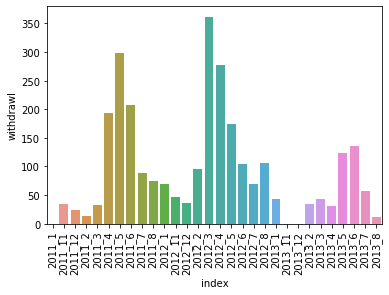

In [16]:
plot = sns.barplot(x="index", y="withdrawl", data=rates)
plot.set_xticklabels(plot.get_xticklabels(), rotation=90)

[Text(0, 0, '2011_1'),
 Text(0, 0, '2011_11'),
 Text(0, 0, '2011_12'),
 Text(0, 0, '2011_2'),
 Text(0, 0, '2011_3'),
 Text(0, 0, '2011_4'),
 Text(0, 0, '2011_5'),
 Text(0, 0, '2011_6'),
 Text(0, 0, '2011_7'),
 Text(0, 0, '2011_8'),
 Text(0, 0, '2012_1'),
 Text(0, 0, '2012_11'),
 Text(0, 0, '2012_12'),
 Text(0, 0, '2012_2'),
 Text(0, 0, '2012_3'),
 Text(0, 0, '2012_4'),
 Text(0, 0, '2012_5'),
 Text(0, 0, '2012_6'),
 Text(0, 0, '2012_7'),
 Text(0, 0, '2012_8'),
 Text(0, 0, '2013_1'),
 Text(0, 0, '2013_11'),
 Text(0, 0, '2013_12'),
 Text(0, 0, '2013_2'),
 Text(0, 0, '2013_3'),
 Text(0, 0, '2013_4'),
 Text(0, 0, '2013_5'),
 Text(0, 0, '2013_6'),
 Text(0, 0, '2013_7'),
 Text(0, 0, '2013_8')]

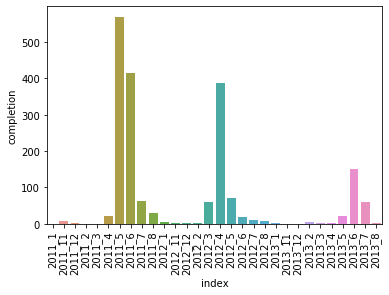

In [17]:
plot = sns.barplot(x="index", y="completion", data=rates)
plot.set_xticklabels(plot.get_xticklabels(), rotation=90)

[Text(0, 0, '2011_1'),
 Text(0, 0, '2011_11'),
 Text(0, 0, '2011_12'),
 Text(0, 0, '2011_2'),
 Text(0, 0, '2011_3'),
 Text(0, 0, '2011_4'),
 Text(0, 0, '2011_5'),
 Text(0, 0, '2011_6'),
 Text(0, 0, '2011_7'),
 Text(0, 0, '2011_8'),
 Text(0, 0, '2012_1'),
 Text(0, 0, '2012_11'),
 Text(0, 0, '2012_12'),
 Text(0, 0, '2012_2'),
 Text(0, 0, '2012_3'),
 Text(0, 0, '2012_4'),
 Text(0, 0, '2012_5'),
 Text(0, 0, '2012_6'),
 Text(0, 0, '2012_7'),
 Text(0, 0, '2012_8'),
 Text(0, 0, '2013_1'),
 Text(0, 0, '2013_11'),
 Text(0, 0, '2013_12'),
 Text(0, 0, '2013_2'),
 Text(0, 0, '2013_3'),
 Text(0, 0, '2013_4'),
 Text(0, 0, '2013_5'),
 Text(0, 0, '2013_6'),
 Text(0, 0, '2013_7'),
 Text(0, 0, '2013_8')]

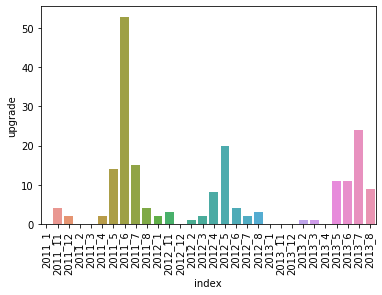

In [18]:
plot = sns.barplot(x="index", y="upgrade", data=rates)
plot.set_xticklabels(plot.get_xticklabels(), rotation=90)

In [19]:
plot_rate_sub = pd.DataFrame(rates['index'])
plot_rate_sub['rate'] = rates['subscribe_rate']
plot_rate_sub['action'] = 'subscribe'

plot_rate_wit = pd.DataFrame(rates['index'])
plot_rate_wit['rate'] = rates['churn_rate']
plot_rate_wit['action'] = 'churn'

plot_rate_com = pd.DataFrame(rates['index'])
plot_rate_com['rate'] = rates['completion_rate']
plot_rate_com['action'] = 'complete'

plot_rate_upg = pd.DataFrame(rates['index'])
plot_rate_upg['rate'] = rates['upgrade_rate']
plot_rate_upg['action'] = 'upgrade'

plot_rate = plot_rate_sub.merge(plot_rate_wit, how="outer").merge(plot_rate_com, how="outer").merge(plot_rate_upg, how="outer")

# logarithmic value of rate for visibility
# plot_rate['log_rate'] = np.log(plot_rate['rate'])
# plot_rate = plot_rate.replace(-np.inf, 0)

plot_rate

,index,rate,action
0,2011_1,0.000000,subscribe
1,2011_2,100.000000,subscribe
2,2011_3,62.971106,subscribe
3,2011_4,64.391001,subscribe
4,2011_5,12.231345,subscribe
...,...,...,...
115,2013_6,0.051626,upgrade
116,2013_7,0.109875,upgrade
117,2013_8,0.040537,upgrade
118,2013_11,0.000000,upgrade


[Text(0, 0, ''),
 Text(0, 0, ''),
 Text(0, 0, ''),
 Text(0, 0, ''),
 Text(0, 0, ''),
 Text(0, 0, ''),
 Text(0, 0, ''),
 Text(0, 0, ''),
 Text(0, 0, ''),
 Text(0, 0, ''),
 Text(0, 0, ''),
 Text(0, 0, ''),
 Text(0, 0, ''),
 Text(0, 0, ''),
 Text(0, 0, ''),
 Text(0, 0, ''),
 Text(0, 0, ''),
 Text(0, 0, ''),
 Text(0, 0, ''),
 Text(0, 0, ''),
 Text(0, 0, ''),
 Text(0, 0, ''),
 Text(0, 0, ''),
 Text(0, 0, ''),
 Text(0, 0, ''),
 Text(0, 0, ''),
 Text(0, 0, ''),
 Text(0, 0, ''),
 Text(0, 0, ''),
 Text(0, 0, '')]

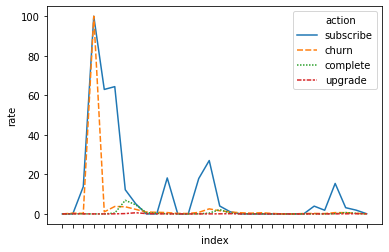

In [20]:
plot = sns.lineplot(x="index", y="rate", hue="action", style="action", data=plot_rate)
plot.set_xticklabels(plot.get_xticklabels(), rotation=90)